In [ ]:
#download the data
!gdown --folder 1EFpwCPxule2EhsCVNte7kWWBi_6d03Lj

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

In [ ]:
# @title Data_preparation
dx   = pd.read_csv('hosp/diagnoses_icd.csv')
adm  = pd.read_csv('hosp/admissions.csv', parse_dates=['admittime'])
meta = pd.read_csv('hosp/d_icd_diagnoses.csv')
admissions_number = dx.groupby(by='subject_id').apply(lambda x: x['hadm_id'].nunique())
icds_number = dx.groupby(by='subject_id').apply(lambda x: x['icd_code'].count())

# merge dx → attach each diagnosis to its admission time
dx = dx.merge(adm[['hadm_id','admittime', 'dischtime', 'admission_type', 'admission_location', 'discharge_location', 'race', 'hospital_expire_flag']], on='hadm_id')
dx = dx.sort_values(['subject_id','admittime'])

In [7]:
# @title M1: Base_statistics: All diseases
disease_counts = dx.groupby('subject_id')['icd_code'].nunique()
valid_ids = disease_counts[disease_counts > 1].index
df = dx[dx['subject_id'].isin(valid_ids)].copy()

# Filter only ICD‑10 codes
df = df[df['icd_version'] == 10].copy()

# Truncate ICD‑10 codes to first 3 characters (e.g., 'C787' → 'C78')
df['icd3'] = df['icd_code'].str[:3]
df['icd_code'] = df['icd3']
df.drop(columns=['icd3'], inplace=True)

# Keep only ICD‑10 records
df_icd10 = df[df['icd_version'] == 10].copy()

# Build list of unique ICD‑10 codes and index mapping
codes = df_icd10['icd_code'].unique().tolist()
N = len(codes)
code_to_idx = {c: i for i, c in enumerate(codes)}

# Initialize an N×N zero‐matrix
cooc = np.zeros((N, N), dtype=int)

# Tally “all codes at time t_i” before “all codes at time t_j” for each patient
for _, grp in df_icd10.groupby('subject_id'):
    # ensure we iterate time‐ordered groups
    times = sorted(grp['admittime'].unique())
    for i, t_i in enumerate(times):
        codes_i = grp.loc[grp['admittime'] == t_i, 'icd_code'].unique()
        for t_j in times[i+1:]:
            codes_j = grp.loc[grp['admittime'] == t_j, 'icd_code'].unique()
            # cross‐count every code in group i as preceding every code in group j
            for ci in codes_i:
                idx_i = code_to_idx[ci]
                for cj in codes_j:
                    idx_j = code_to_idx[cj]
                    cooc[idx_i, idx_j] += 1

df_cooc = pd.DataFrame(cooc, index=codes, columns=codes)

In [ ]:
df_cooc.to_csv('./cooc_matrix_for_icd10_time_ordered.csv', index=True)

In [8]:
df_all_icd3 = pd.DataFrame({'icd3': codes})
df_all_icd3.to_excel('all_icd3_codes.xlsx', index=False)

# Find oncology-related diseases
def is_cancer_code(code):
    code_str = str(code).strip()
    if code_str.startswith('C'):
        return True
    if code_str.startswith('D') and len(code_str) >= 3:
        num_part = code_str[1:3]
        if num_part.isdigit():
            num = int(num_part)
            return (0 <= num <= 9) or (37 <= num <= 48)
    return False

cancer_icd3 = [code for code in codes if is_cancer_code(code)]

df_cancer_icd3 = pd.DataFrame({'icd3': cancer_icd3})
df_cancer_icd3.to_excel('cancer_icd3_codes.xlsx', index=False)


print(f"Saved {len(codes)} total ICD‑10 categories to: results/all_icd3_codes.xlsx")
print(f"Saved {len(cancer_icd3)} cancer-related ICD‑10 categories to: results/cancer_icd3_codes.xlsx")


Saved 1704 total ICD‑10 categories to: results/all_icd3_codes.xlsx
Saved 111 cancer-related ICD‑10 categories to: results/cancer_icd3_codes.xlsx


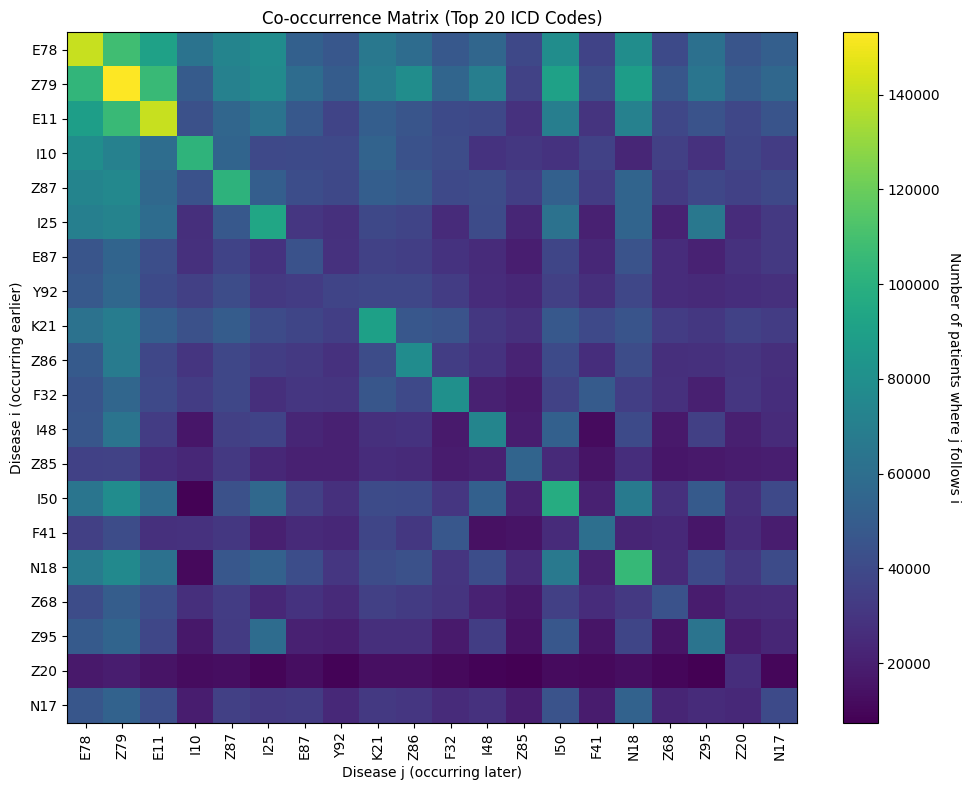

In [9]:
topk      = df['icd_code'].value_counts().nlargest(20)
top_codes = topk.index.tolist()
idx       = [code_to_idx[c] for c in top_codes]

mat = cooc[np.ix_(idx, idx)]
plt.figure(figsize=(10, 8))
im = plt.imshow(mat, aspect='auto')

# 4. Configure axis tick labels
plt.xticks(range(20), top_codes, rotation=90)
plt.yticks(range(20), top_codes)

# 5. Axis labels and title in English
plt.xlabel('Disease j (occurring later)')
plt.ylabel('Disease i (occurring earlier)')
plt.title('Co‑occurrence Matrix (Top 20 ICD Codes)')

# 6. Add colorbar legend indicating patient counts
cbar = plt.colorbar(im)
cbar.set_label('Number of patients where j follows i', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [10]:
# @title M1: Base_statistics: Only cancer
cancer_codes = [code for code in df_cooc.index if is_cancer_code(code)]
print(f"Found {len(cancer_codes)} cancer-related ICD-10 codes")

# Create the submatrix (cancer diseases x all diseases)
cancer_cooc_submatrix = df_cooc.loc[cancer_codes, :]
cancer_cooc_submatrix.to_csv('cancer_cooccurrence_submatrix.csv')
print("Submatrix saved as 'cancer_cooccurrence_submatrix.csv'")


Found 111 cancer-related ICD-10 codes
Submatrix saved as 'cancer_cooccurrence_submatrix.csv'


In [11]:
def visualize_thresholded_matrix(cancer_cooc_submatrix, threshold=1000):
    # Apply threshold
    thresholded = cancer_cooc_submatrix.copy()
    thresholded[thresholded < threshold] = 0

    # Remove empty rows and columns
    thresholded = thresholded.loc[~(thresholded == 0).all(axis=1)]
    thresholded = thresholded.loc[:, ~(thresholded == 0).all(axis=0)]

    # Plot heatmap
    plt.figure(figsize=(15, 12))
    sns.heatmap(
        np.log1p(thresholded),  # Log transform for better visualization
        cmap='viridis',
        cbar_kws={'label': 'Log(Co-occurrence Count)'}
    )
    plt.title(f'Cancer-Disease Co-occurrence (Threshold > {threshold})')
    plt.xlabel('Disease ICD Codes')
    plt.ylabel('Cancer ICD Codes')
    plt.tight_layout()
    plt.savefig('cancer_cooccurrence_thresholded.png', dpi=300)
    plt.close()

    return thresholded

# Task 2: Show information for a specific ICD code
def show_icd_info(cancer_cooc_submatrix, icd_code):
    results = {}

    # Check rows (cancer codes)
    if icd_code in cancer_cooc_submatrix.index:
        row = cancer_cooc_submatrix.loc[icd_code]
        non_zero = row[row > 0]
        results['type'] = 'Cancer'
        results['co-occurrences'] = non_zero.sort_values(ascending=False)

    # Check columns (all diseases)
    elif icd_code in cancer_cooc_submatrix.columns:
        col = cancer_cooc_submatrix[icd_code]
        non_zero = col[col > 0]
        results['type'] = 'Disease'
        results['co-occurrences'] = non_zero.sort_values(ascending=False)

    else:
        return f"ICD code {icd_code} not found in the co-occurrence matrix"

    # Add summary statistics
    results['total_cooccurrences'] = results['co-occurrences'].sum()
    results['num_relationships'] = len(results['co-occurrences'])

    return results

In [12]:
# Check significance

def find_significant_relationships(cancer_cooc_submatrix, total_patients=217403):
    """
    Perform Fisher's exact test for each pair (cancer, non-cancer disease),
    excluding any disease on the x-axis that is itself a cancer code.

    Parameters:
    - cancer_cooc_submatrix: DataFrame where
        * index = cancer ICD‑10 codes (rows)
        * columns = co‑occurring ICD‑10 codes (may include cancers)
        * values = patient counts where col occurred after row
    - total_patients: integer, total number of patients in the cohort

    Returns:
    - results_df: DataFrame of significant (cancer, disease) pairs with odds ratios
      and FDR‑adjusted p‑values, sorted by adjusted p‑value ascending.
    """
    # 1. Identify non‑cancer disease columns
    cancer_codes = set(cancer_cooc_submatrix.index)
    non_cancer_cols = [d for d in cancer_cooc_submatrix.columns if d not in cancer_codes]

    # 2. Precompute marginal totals
    cancer_totals  = cancer_cooc_submatrix[non_cancer_cols].sum(axis=1)  # row sums (only non‑cancer columns)
    disease_totals = cancer_cooc_submatrix.loc[:, non_cancer_cols].sum(axis=0)  # col sums

    # 3. Iterate through non-zero cancer→disease pairs
    results = []
    for cancer in cancer_cooc_submatrix.index:
        for disease in non_cancer_cols:
            a = cancer_cooc_submatrix.at[cancer, disease]
            if a < 10:
                continue  # skip low counts
            b = cancer_totals[cancer] - a
            c = disease_totals[disease] - a
            d = total_patients - (a + b + c)

            # 4. Fisher's exact test (one‑sided)
            try:
                odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='greater')
            except Exception:
                continue

            results.append({
                'cancer': cancer,
                'disease': disease,
                'cooccurrence': a,
                'odds_ratio': odds_ratio,
                'p_value': p_value
            })

    # 5. Assemble results and adjust p‑values
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        pvals = results_df['p_value'].values
        _, pvals_adj, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
        results_df['p_value_adj'] = pvals_adj
        results_df = results_df.sort_values('p_value_adj').reset_index(drop=True)

    return results_df


In [ ]:
# Check statistically significant relationships
significant_relationships = find_significant_relationships(cancer_cooc_submatrix)
significant_relationships = significant_relationships.sort_values('p_value_adj')
significant_relationships.to_csv('significant_cancer_relationships.csv', index=False)

print("\nSignificant relationships (sorted by adjusted p-value):")
significant_relationships

In [ ]:
#Show more-than-threshold relationships
threshold = 1500 # @param {"type":"integer"}

thresholded_matrix = visualize_thresholded_matrix(cancer_cooc_submatrix, threshold=threshold)
thresholded_matrix.to_csv('thresholded_cancer_cooccurrence_1500.csv')
thresholded_matrix